“Провести анализ с помощью SSA любом из временных рядов с первого занятия. При желании, можно воспользоваться своим временным рядом (работа, kaggle и тд). Посмотрите на результаты с разными длинами окон. Обязательно визуализируйте результаты, аналогично материалу с занятия.”

In [1]:
# Load the usual suspects:
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

# Fiddle with figure settings here:
plt.rcParams['figure.figsize'] = (10,8)
plt.rcParams['font.size'] = 14
plt.rcParams['image.cmap'] = 'plasma'
plt.rcParams['axes.linewidth'] = 2
# Set the default colour cycle (in case someone changes it...)
from cycler import cycler
cols = plt.get_cmap('tab10').colors
plt.rcParams['axes.prop_cycle'] = cycler(color=cols)

# A simple little 2D matrix plotter, excluding x and y labels.
def plot_2d(m, title=""):
    plt.imshow(m)
    plt.xticks([])
    plt.yticks([])
    plt.title(title)

In [6]:

sales_of_company = pd.read_csv("Series/monthly-sales-of-company-x-jan-6.csv")
robberies_in_boston = pd.read_csv("Series/monthly-boston-armed-robberies-j.csv")
airlines_passengers = pd.read_csv("Series/international-airline-passengers.csv")
mean_monthly_temp = pd.read_csv("Series/mean-monthly-air-temperature-deg.csv")
dowjones_closing = pd.read_csv("Series/weekly-closings-of-the-dowjones-.csv")
female_births = pd.read_csv("Series/daily-total-female-births-in-cal.csv")


In [7]:
all_series = {
    "Sales": sales_of_company["Count"],
    "Robberies": robberies_in_boston["Count"],
    "Temperature": mean_monthly_temp["Deg"],
    "Dow_Jones": dowjones_closing["Close"],
    "Births": female_births["Count"]
}

In [4]:
class SSA(object):
    
    __supported_types = (pd.Series, np.ndarray, list)
    
    def __init__(self, tseries, L, save_mem=True):
        """
        Decomposes the given time series with a singular-spectrum analysis. Assumes the values of the time series are
        recorded at equal intervals.
        
        Parameters
        ----------
        tseries : The original time series, in the form of a Pandas Series, NumPy array or list. 
        L : The window length. Must be an integer 2 <= L <= N/2, where N is the length of the time series.
        save_mem : Conserve memory by not retaining the elementary matrices. Recommended for long time series with
            thousands of values. Defaults to True.
        
        Note: Even if an NumPy array or list is used for the initial time series, all time series returned will be
        in the form of a Pandas Series or DataFrame object.
        """
        
        # Tedious type-checking for the initial time series
        if not isinstance(tseries, self.__supported_types):
            raise TypeError("Unsupported time series object. Try Pandas Series, NumPy array or list.")
        
        # Checks to save us from ourselves
        self.N = len(tseries)
        if not 2 <= L <= self.N/2:
            raise ValueError("The window length must be in the interval [2, N/2].")
        
        self.L = L
        self.orig_TS = pd.Series(tseries)
        self.K = self.N - self.L + 1
        
        # Embed the time series in a trajectory matrix
        self.X = np.array([self.orig_TS.values[i:L+i] for i in range(0, self.K)]).T
        
        # Decompose the trajectory matrix
        self.U, self.Sigma, VT = np.linalg.svd(self.X)
        self.d = np.linalg.matrix_rank(self.X)
        
        self.TS_comps = np.zeros((self.N, self.d))
        
        if not save_mem:
            # Construct and save all the elementary matrices
            self.X_elem = np.array([ self.Sigma[i]*np.outer(self.U[:,i], VT[i,:]) for i in range(self.d) ])

            # Diagonally average the elementary matrices, store them as columns in array.           
            for i in range(self.d):
                X_rev = self.X_elem[i, ::-1]
                self.TS_comps[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]
            
            self.V = VT.T
        else:
            # Reconstruct the elementary matrices without storing them
            for i in range(self.d):
                X_elem = self.Sigma[i]*np.outer(self.U[:,i], VT[i,:])
                X_rev = X_elem[::-1]
                self.TS_comps[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]
            
            self.X_elem = "Re-run with save_mem=False to retain the elementary matrices."
            
            # The V array may also be very large under these circumstances, so we won't keep it.
            self.V = "Re-run with save_mem=False to retain the V matrix."
        
        # Calculate the w-correlation matrix.
        self.calc_wcorr()
            
    def components_to_df(self, n=0):
        """
        Returns all the time series components in a single Pandas DataFrame object.
        """
        if n > 0:
            n = min(n, self.d)
        else:
            n = self.d
        
        # Create list of columns - call them F0, F1, F2, ...
        cols = ["F{}".format(i) for i in range(n)]
        return pd.DataFrame(self.TS_comps[:, :n], columns=cols, index=self.orig_TS.index)
            
    
    def reconstruct(self, indices):
        """
        Reconstructs the time series from its elementary components, using the given indices. Returns a Pandas Series
        object with the reconstructed time series.
        
        Parameters
        ----------
        indices: An integer, list of integers or slice(n,m) object, representing the elementary components to sum.
        """
        if isinstance(indices, int): indices = [indices]
        
        ts_vals = self.TS_comps[:,indices].sum(axis=1)
        return pd.Series(ts_vals, index=self.orig_TS.index)
    
    def calc_wcorr(self):
        """
        Calculates the w-correlation matrix for the time series.
        """
             
        # Calculate the weights
        w = np.array(list(np.arange(self.L)+1) + [self.L]*(self.K-self.L-1) + list(np.arange(self.L)+1)[::-1])
        
        def w_inner(F_i, F_j):
            return w.dot(F_i*F_j)
        
        # Calculated weighted norms, ||F_i||_w, then invert.
        F_wnorms = np.array([w_inner(self.TS_comps[:,i], self.TS_comps[:,i]) for i in range(self.d)])
        F_wnorms = F_wnorms**-0.5
        
        # Calculate Wcorr.
        self.Wcorr = np.identity(self.d)
        for i in range(self.d):
            for j in range(i+1,self.d):
                self.Wcorr[i,j] = abs(w_inner(self.TS_comps[:,i], self.TS_comps[:,j]) * F_wnorms[i] * F_wnorms[j])
                self.Wcorr[j,i] = self.Wcorr[i,j]
    
    def plot_wcorr(self, min=None, max=None):
        """
        Plots the w-correlation matrix for the decomposed time series.
        """
        if min is None:
            min = 0
        if max is None:
            max = self.d
        
        if self.Wcorr is None:
            self.calc_wcorr()
        
        ax = plt.imshow(self.Wcorr)
        plt.xlabel(r"$\tilde{F}_i$")
        plt.ylabel(r"$\tilde{F}_j$")
        plt.colorbar(ax.colorbar, fraction=0.045)
        ax.colorbar.set_label("$W_{i,j}$")
        plt.clim(0,1)
        
        # For plotting purposes:
        if max == self.d:
            max_rnge = self.d-1
        else:
            max_rnge = max
        
        plt.xlim(min-0.5, max_rnge+0.5)
        plt.ylim(max_rnge+0.5, min-0.5)

### 1 Загрузка данных

In [76]:
series = all_series['Temperature']

In [77]:
series.head(4)

0    40.6
1    40.8
2    44.4
3    46.7
Name: Deg, dtype: float64

In [78]:
series

0      40.6
1      40.8
2      44.4
3      46.7
4      54.1
       ... 
235    61.8
236    58.2
237    46.7
238    46.6
239    37.8
Name: Deg, Length: 240, dtype: float64

### 2 Построение графика данных

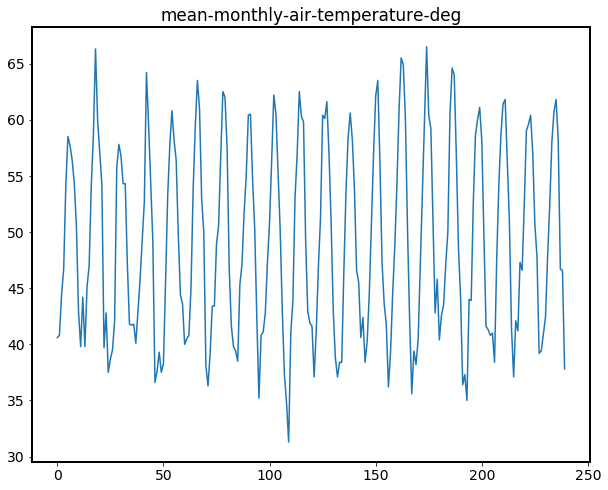

In [79]:

series.plot()
plt.title("mean-monthly-air-temperature-deg");

### 3 Декомпозиция Временного ряда С помощью SSA

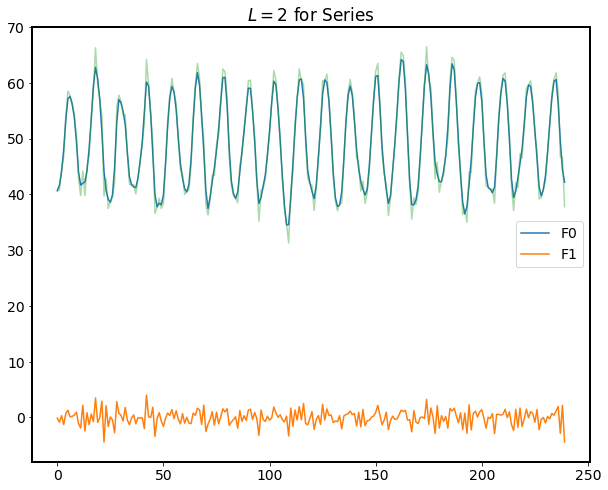

In [80]:
series_ssa_L2 = SSA(series, 2)
series_ssa_L2.components_to_df().plot()
series_ssa_L2.orig_TS.plot(alpha=0.4)

plt.title(r"$L=2$ for Series");

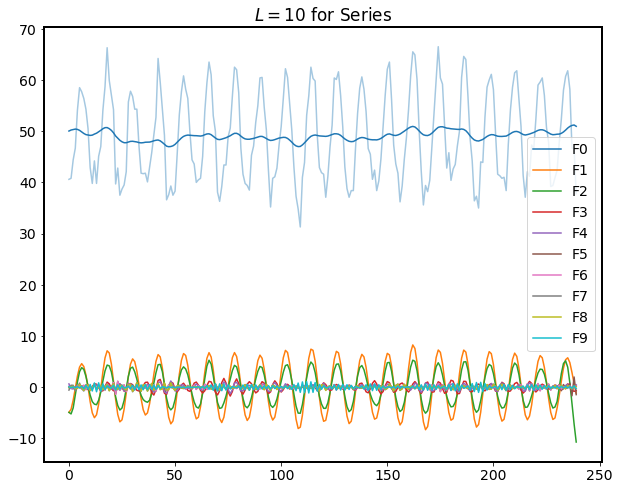

In [81]:
series_ssa_L2 = SSA(series, 10)
series_ssa_L2.components_to_df().plot()
series_ssa_L2.orig_TS.plot(alpha=0.4)

plt.title(r"$L=10$ for Series");

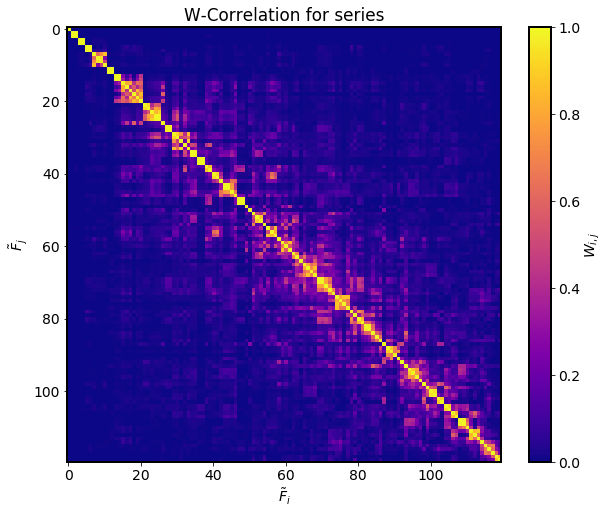

In [84]:
window = 120
series_ssa = SSA(series, window)
series_ssa.plot_wcorr()
plt.title("W-Correlation for series");

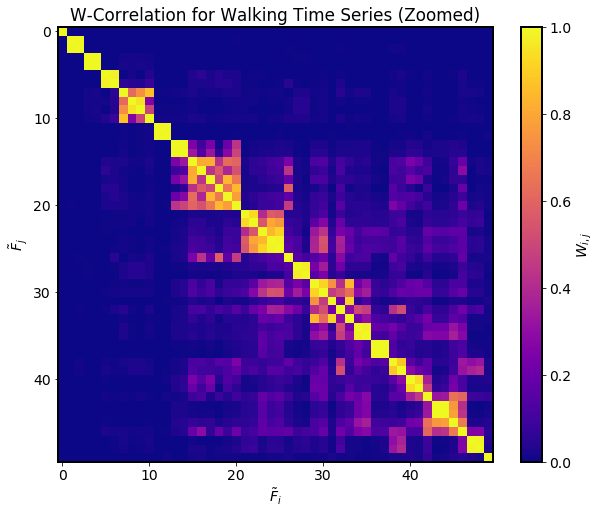

In [85]:
series_ssa.plot_wcorr(max=49)
plt.title("W-Correlation for Walking Time Series (Zoomed)");

Начиная с первых пяти элементарных компонентов, мы сформируем следующие группы и построим их график:

\begin{align*}
    \tilde{F}^{(0)} & = \tilde{F}_0 \\
    \tilde{F}^{(1)} & = \tilde{F}_1 + \tilde{F}_2 \\
    \tilde{F}^{(2)} & = \tilde{F}_3 + \tilde{F}_4 \\
\end{align*}

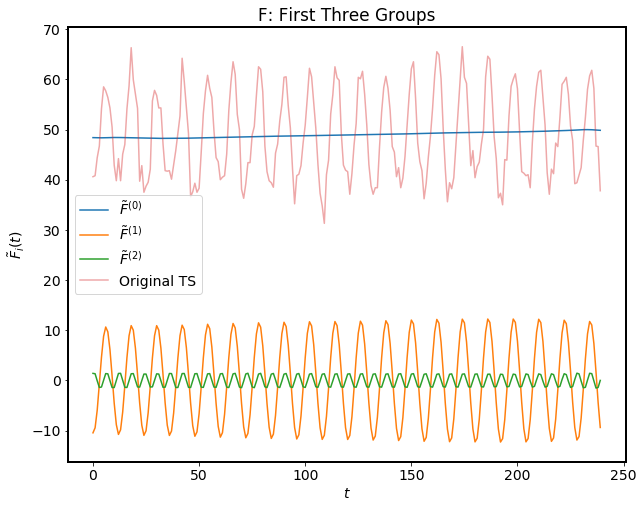

In [86]:

series_ssa.reconstruct(0).plot()
series_ssa.reconstruct([1,2]).plot()
series_ssa.reconstruct([3,4]).plot()
series_ssa.orig_TS.plot(alpha=0.4)
plt.title("F: First Three Groups")
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
legend = [r"$\tilde{{F}}^{{({0})}}$".format(i) for i in range(3)] + ["Original TS"]
plt.legend(legend);

Из двух графиков ясно, что компонент $\tilde{F}^{(0)}$ является трендом, в то время как $\tilde{F}^{(1)}$ и $\tilde{F}^{(2)}$ являются двумя доминирующими периодичностями. Поскольку долгосрочный тренд по существу плоский, последующие компоненты состоят из отклонений выше и ниже нуля. (Примечание: если вы вычитаете среднее значение из временного ряда перед разложением с помощью SSA, компонент тренда $\tilde{F}_0$ исчезнет.)

Если мы решим сложить вместе первые пять элементарных компонентов, мы получим картину гладкой низкочастотной периодичности, присутствующей в серии:

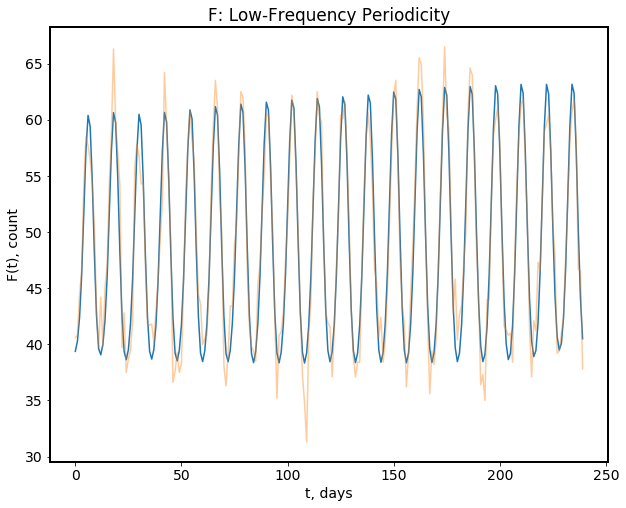

In [87]:

series_ssa.reconstruct(slice(0,5)).plot()
series_ssa.orig_TS.plot(alpha=0.4)
plt.title("F: Low-Frequency Periodicity")
plt.xlabel(r"t, days")
plt.ylabel("F(t), count");

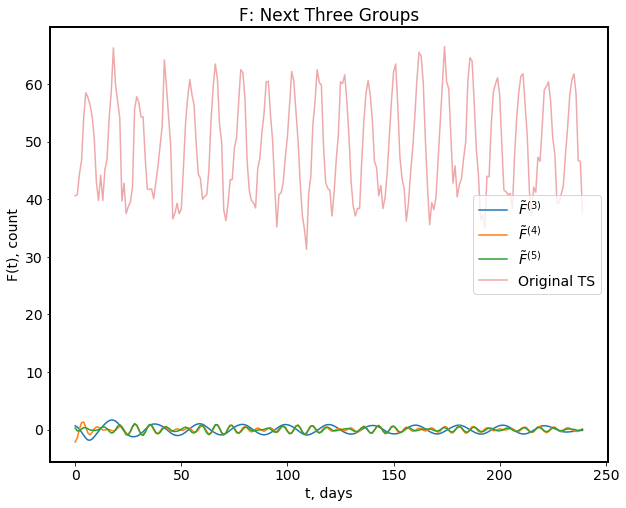

In [88]:

series_ssa.reconstruct([5,6]).plot()
(series_ssa.reconstruct([7,8])).plot()
(series_ssa.reconstruct([9,10])).plot()
series_ssa.orig_TS.plot(alpha=0.4)
plt.title("F: Next Three Groups")
plt.xlabel(r"t, days")
plt.ylabel("F(t), count")
legend = [r"$\tilde{{F}}^{{({0})}}$".format(i) for i in range(3,6)] + ["Original TS"]
plt.legend(legend);

Сгруппированные компоненты $\tilde{F}_3$, $\tilde{F}_4$ и $\tilde{F}_5$ представляют собой еще три периодичности с различными частотами, но приблизительно одинаковыми амплитудами. В данных временных рядов с большим количеством высокочастотных компонентов SSA обычно генерирует ряд стабильных гармонических компонентов, которые хорошо отделены друг от друга (т.е. низкая w-корреляция). Однако без некоторого знания предметной области процесса, порождающего сам временной ряд, трудно сказать, соответствуют ли эти компоненты интерпретируемым процессам, которые работают независимо, или же набор компонентов следует суммировать и рассматривать как единый компонент. SSA слепа к реальности. В этом случае мы суммируем эти компоненты вместе и проверим периодичность, которую они представляют:

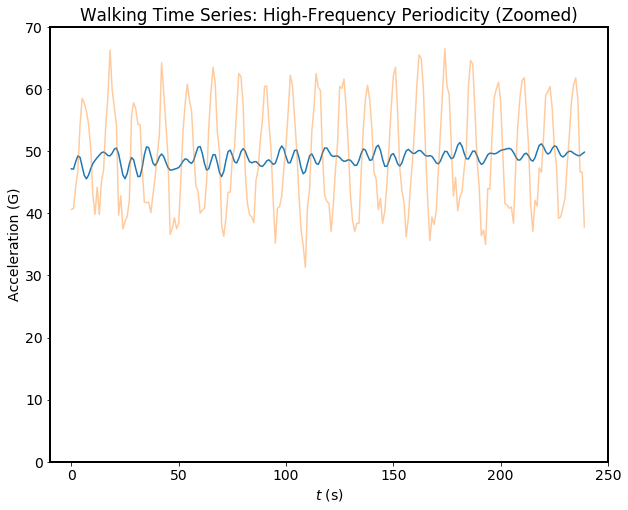

In [92]:
series_ssa.reconstruct([0] + [i for i in range(5,11)]).plot()
series_ssa.orig_TS.plot(alpha=0.4)
plt.title("Walking Time Series: High-Frequency Periodicity (Zoomed)")
plt.xlabel(r"$t$ (s)")
plt.ylabel("Acceleration (G)")
plt.ylim(0, 70)
plt.xlim(-10,250);

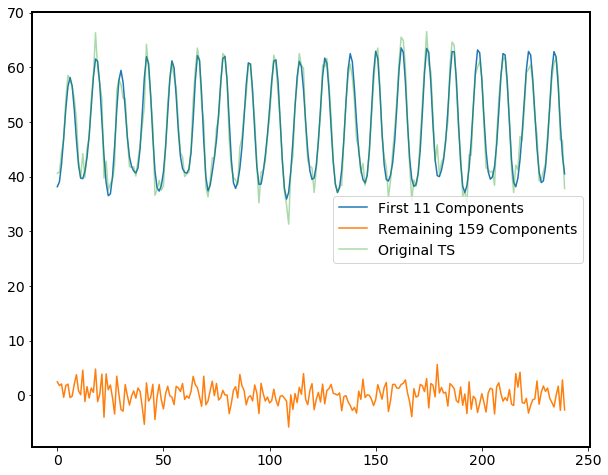

In [93]:

series_ssa.reconstruct(slice(0,11)).plot()
series_ssa.reconstruct(slice(11,window)).plot()
series_ssa.orig_TS.plot(alpha=0.4)
# plt.xlim(0,50)
plt.legend(["First 11 Components", "Remaining 159 Components", "Original TS"]);

Приведенный выше график показывает, что сумма первых 11 компонентов адекватно отражает основную, лежащую в основе периодичность временного ряда акселерометра. Однако сумма оставшихся 339 компонентов (эквивалентная остаточному ряду $F_{\text{orig}} - \sum_{i=0}^{10} \tilde{F}_i$) по-прежнему содержит большие регулярные шипы, расположенные примерно на расстоянии 1 секунды друг от друга, вероятно, связанные с событиями ходьбы. Однако основная форма SSA, представленная здесь, не очень хорошо справляется с этими типами резких периодичностей, вместо этого распространяя "сигнал" от этих периодичностей по многим элементарным компонентам. Иными словами, регулярная часть сигнала не может быть отделена от шума. Я не могу предложить здесь решение; вместо этого проблема (будь то исследовательский анализ, извлечение сигналов, предварительная обработка данных...) будет диктовать, как обращаться с подобными ситуациями.